# Connecting Twitter Content to 2020 Presidential Election

In this analysis, we try to understand the relationship between tweets published by Presidential Election Candidates and the candidates' polls.

The code below consists of 3 main parts:

A) Dataset Development

B) Exploratory Analysis

C) Regression Analysis

## Data Description

The data I used in this study consists of two parts: the polling data from public media and the text data from two Candidates’ Twitter accounts. 

### A) Dataset Development

#### 1) Polling Data
The polling data used in this study is collected by a well-known political journalism website FiveThirtyEight.

In [163]:
import pandas as pd
import datetime
poll_538=pd.read_csv("presidential_poll_averages_2020.csv")
poll_538.head()

,cycle,state,modeldate,candidate_name,pct_estimate,pct_trend_adjusted
0,2020,Wyoming,10/19/2020,Joseph R. Biden Jr.,29.33796,29.85487
1,2020,Wisconsin,10/19/2020,Joseph R. Biden Jr.,50.84814,50.97334
2,2020,West Virginia,10/19/2020,Joseph R. Biden Jr.,35.32911,35.71060
3,2020,Washington,10/19/2020,Joseph R. Biden Jr.,58.46651,59.32447
4,2020,Virginia,10/19/2020,Joseph R. Biden Jr.,52.89655,53.37989


In [164]:
poll_538.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25725 entries, 0 to 25724
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cycle               25725 non-null  int64  
 1   state               25725 non-null  object 
 2   modeldate           25725 non-null  object 
 3   candidate_name      25725 non-null  object 
 4   pct_estimate        25725 non-null  float64
 5   pct_trend_adjusted  25725 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB


In [165]:
#Check missing value
poll_538.isna().sum()

cycle                 0
state                 0
modeldate             0
candidate_name        0
pct_estimate          0
pct_trend_adjusted    0
dtype: int64

I removed the cycle and adjusted poll columns since only estimated poll data is utilized in the analysis, and cycle column does not provide extra information. Also I filtered the state column with national poll for analysis.

In [167]:
#filter state column
poll_538=poll_538[poll_538['state']=='National']
#drop columns
poll_538=poll_538.drop(columns=['state','cycle','pct_trend_adjusted'])
poll_538.head()

,modeldate,candidate_name,pct_estimate
24,10/19/2020,Joseph R. Biden Jr.,52.40319
80,10/19/2020,Donald Trump,41.78621
136,10/19/2020,Convention Bounce for Joseph R. Biden Jr.,40.23951
192,10/19/2020,Convention Bounce for Donald Trump,39.61763
248,10/18/2020,Joseph R. Biden Jr.,52.32499


Since the effect of Convention Bounce is out of the scope in this analysis, I also excluded that. Then, I converted the modeldate column to datetime type for matching the tweet data.

In [130]:
#convert modeldate to datetime type
poll_538['modeldate'] = pd.to_datetime(poll_538['modeldate'], 
                                       format = '%m/%d/%Y',
                                       infer_datetime_format=True)

#rename column
poll_538=poll_538.rename(columns={"modeldate": "Date", 
                                  "candidate_name": "Candidates", 
                                  "pct_estimate": "Poll_est"})

#convert Candidates to string type and filter out Convention Bounce data
poll_538["Candidates"]=pd.Series(poll_538["Candidates"],dtype="string")
poll_538=poll_538[poll_538["Candidates"].str.contains('Convention Bounce')==False]

#Edit label name
poll_538["Candidates"]=poll_538["Candidates"].str.replace('Joseph R. Biden Jr.', 
                                                          'Biden', regex=False)
poll_538["Candidates"]=poll_538["Candidates"].str.replace('Donald Trump', 
                                                          'Trump', regex=False)

#Candidate to dummy variable for analysis
poll_538['Candidates_n']=poll_538['Candidates']
poll_538['Candidates_n'].replace(to_replace=['Biden', 'Trump'], 
                                 value=[0, 1], inplace=True)

poll_538.head()

,Date,Candidates,Poll_est,Candidates_n
24,2020-10-19,Biden,52.40319,0
80,2020-10-19,Trump,41.78621,1
248,2020-10-18,Biden,52.32499,0
304,2020-10-18,Trump,41.89364,1
472,2020-10-17,Biden,52.31566,0


The period I analyzed in this research are from August 19th to October 19th, 2020. Therefore, I checked the Date and remove poll records before August 19th.

In [131]:
poll_538['Date'].describe()

count                     472
unique                    236
top       2020-03-13 00:00:00
freq                        2
first     2020-02-27 00:00:00
last      2020-10-19 00:00:00
Name: Date, dtype: object

In [132]:
cutoff_date=datetime.date(2020, 8, 19)
poll_538=poll_538[poll_538['Date'].dt.date > cutoff_date]
poll_538=poll_538.reset_index(drop=True)
poll_538.head()

,Date,Candidates,Poll_est,Candidates_n
0,2020-10-19,Biden,52.40319,0
1,2020-10-19,Trump,41.78621,1
2,2020-10-18,Biden,52.32499,0
3,2020-10-18,Trump,41.89364,1
4,2020-10-17,Biden,52.31566,0


In [133]:
#Days till vote day columns
vote_2020=datetime.datetime(2020, 11, 3)
poll_538['Days_till_vote']=(vote_2020-poll_538['Date']).astype('timedelta64[D]')
poll_538.head()

,Date,Candidates,Poll_est,Candidates_n,Days_till_vote
0,2020-10-19,Biden,52.40319,0,15.0
1,2020-10-19,Trump,41.78621,1,15.0
2,2020-10-18,Biden,52.32499,0,16.0
3,2020-10-18,Trump,41.89364,1,16.0
4,2020-10-17,Biden,52.31566,0,17.0


In [134]:
poll_538.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            122 non-null    datetime64[ns]
 1   Candidates      122 non-null    string        
 2   Poll_est        122 non-null    float64       
 3   Candidates_n    122 non-null    int64         
 4   Days_till_vote  122 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1), string(1)
memory usage: 4.9 KB


#### 2) Tweet Data
We retrieved tweets that are published from Donald Trump and Joe Biden’s official Twitter account during August to October 2020 with the help of the user timeline function from tweepy library and Twitter API.

From the JSON file we obtained, we extracted in each tweet, the created date and time, tweet id, text of the tweet, retweet count, favorite count and so on.

##### Donald Trump's tweets data

In [135]:
tweet_trump=pd.read_csv('trump_tweet.csv')
pd.set_option('display.max_colwidth', None)
tweet_trump.head()

,created_at,tweetid,text,retweet_count,favorite_count,in_reply_to_status_id,in_reply_to_screen_name,username,followers_count
0,2020-10-15 01:56:34,1316558554732531713,"Joe Biden must immediately release all emails, meetings, phone calls, transcripts, and records related to his invol… https://t.co/y5ZXNiUuER",7321,18921,None,None,Donald J. Trump,87256412
1,2020-10-15 01:54:45,1316558095628206080,"I was thrilled to be back in the American Heartland with thousands of loyal, hardworking IOWA Patriots! 20 days fro… https://t.co/NTbh9vowLc",3875,14285,None,None,Donald J. Trump,87256412
2,2020-10-15 01:52:44,1316557590894006272,THANK YOU IOWA! #MAGA https://t.co/cD5CaGu1cr,3211,12884,None,None,Donald J. Trump,87256412
3,2020-10-14 23:06:06,1316515656360099841,https://t.co/d7HGsJhj8Q,32012,69557,None,None,Donald J. Trump,87256412
4,2020-10-14 22:56:26,1316513223802187776,https://t.co/fVcn4CO3SQ,12844,33163,None,None,Donald J. Trump,87256412


In [136]:
tweet_trump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   created_at               1112 non-null   object
 1   tweetid                  1112 non-null   int64 
 2   text                     1112 non-null   object
 3   retweet_count            1112 non-null   int64 
 4   favorite_count           1112 non-null   int64 
 5   in_reply_to_status_id    1112 non-null   object
 6   in_reply_to_screen_name  1112 non-null   object
 7   username                 1112 non-null   object
 8   followers_count          1112 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 78.3+ KB


In [137]:
#Check missing value
tweet_trump.isna().sum()

created_at                 0
tweetid                    0
text                       0
retweet_count              0
favorite_count             0
in_reply_to_status_id      0
in_reply_to_screen_name    0
username                   0
followers_count            0
dtype: int64

The columns in_reply_to_status_id, in_reply_to_screen_name and followers_count are out of the scope of this research, and the username is not informative since we already know all the tweets are from Donald Trump's account, we will remove those columns.

Also, we need to transform and convert date column to date datatype, and extract the features from text column to indicate if the tweet mention opponents or own team.

In [138]:
#drop unnecessary columns
tweet_trump=tweet_trump.drop(columns=['in_reply_to_status_id',
                                      'in_reply_to_screen_name',
                                      'followers_count',
                                      'username'])

#convert and transform date columns
tweet_trump["created_at"]=pd.to_datetime(tweet_trump["created_at"], 
                                         format = '%Y-%m-%d %H:%M:%S',
                                         infer_datetime_format=True)
tweet_trump['date'] = tweet_trump['created_at'].dt.date

#Create column to indicate if the tweet mention opponents or own team
mention_oppo=[]
mention_team=[]
for i in tweet_trump['text'].values:
    if ('joe' or 'biden' or "kamala" or 'harris' 
        or 'democrat' or 'democrats') in i.lower():
        mention_oppo.append(True)
    else:
        mention_oppo.append(False)
    if ('donald' or 'trump' or "mike" 
        or 'pence' or 'republican' or 'republicans') in i.lower():
        mention_team.append(True)
    else:
        mention_team.append(False)
        
tweet_trump["mention_oppo"]=pd.Series(mention_oppo,dtype="boolean")
tweet_trump["mention_team"]=pd.Series(mention_team,dtype="boolean")

From the text data, we could further extract other linguistics features based on the interest of our study. I have retrieved sentiment score from text columns.

In [139]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
comp=[]
for i in tweet_trump['text'].values:
    score=analyzer.polarity_scores(i)
    comp.append(score['compound'])
    
#-1 (extremely negative) to 1 (extremely positive)
tweet_trump['vader_comp_sent']=pd.Series(comp,dtype="float64")

Also, we are interested in the wording they chose in tweets, so we counted the number of the appearance of words in a tweet that matches the Power and Submit tag categories from General Inquirer Dictionary and constructed as “Power word count” and “Submit word count” variables.

In [140]:
#load dictionary
lexicon=pd.read_excel("General Inquiry lexicon.xls")
lexicon.head()

,Entry,Source,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,...,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othrtags,Defined
0,NaN,NaN,1915,2291,1045,557,1160,833,1902,689,...,30,193,126,175,132,25,428,368,NaN,NaN
1,A,H4Lvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DET ART,| article: Indefinite singular article--some or any one
2,ABANDON,H4Lvd,NaN,Negativ,NaN,NaN,Ngtv,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|
3,ABANDONMENT,H4,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Noun,|
4,ABATE,H4Lvd,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|


In [141]:
#generate word list for diff categories [Power and Submit]
Power=lexicon[(lexicon["Power"]=="Power")]["Entry"].tolist()

#remove hashtag
clean=[]
for i in Power:
    if i.isalpha()==False:
        i_clean=i[:-2]
        clean.append(i_clean)
    else:
        clean.append(i)
Power=clean

Submit=lexicon[(lexicon["Submit"]=="Submit")]["Entry"].tolist()

# remove hashtag
clean=[]
for i in Submit:
    if i.isalpha()==False:
        i_clean=i[:-2]
        clean.append(i_clean)
    else:
        clean.append(i)
Submit=clean
print("Power:", Power[:5])
print("Submit:", Submit[:5])

Power: ['ABOLISH', 'ACCOMPLISH', 'ACCOMPLISHMENT', 'ACCORD', 'ACHIEVEMENT']
Submit: ['ABDICATE', 'ABJECT', 'ABSCOND', 'ACCEPT', 'ADJUST']


In [142]:
Power_ct=[]
for i in tweet_trump['text'].values:
    count=0
    for w in Power:
        if w.lower() in i.lower():
            count+=1
    Power_ct.append(count)
tweet_trump['Power']=pd.Series(Power_ct,dtype="int64")

Submit_ct=[]
for i in tweet_trump['text'].values:
    count=0
    for w in Submit:
        if w.lower() in i.lower():
            count+=1
    Submit_ct.append(count)
tweet_trump['Submit']=pd.Series(Submit_ct,dtype="int64")

tweet_trump.head()

,created_at,tweetid,text,retweet_count,favorite_count,date,mention_oppo,mention_team,vader_comp_sent,Power,Submit
0,2020-10-15 01:56:34,1316558554732531713,"Joe Biden must immediately release all emails, meetings, phone calls, transcripts, and records related to his invol… https://t.co/y5ZXNiUuER",7321,18921,2020-10-15,True,False,0.0000,0,0
1,2020-10-15 01:54:45,1316558095628206080,"I was thrilled to be back in the American Heartland with thousands of loyal, hardworking IOWA Patriots! 20 days fro… https://t.co/NTbh9vowLc",3875,14285,2020-10-15,False,False,0.7424,3,1
2,2020-10-15 01:52:44,1316557590894006272,THANK YOU IOWA! #MAGA https://t.co/cD5CaGu1cr,3211,12884,2020-10-15,False,False,0.5461,0,0
3,2020-10-14 23:06:06,1316515656360099841,https://t.co/d7HGsJhj8Q,32012,69557,2020-10-14,False,False,0.0000,0,0
4,2020-10-14 22:56:26,1316513223802187776,https://t.co/fVcn4CO3SQ,12844,33163,2020-10-14,False,False,0.0000,0,0


##### Joe Biden's tweets data

I have implemented the same process of data cleaning and transformation to Joe Biden's tweets data.

In [143]:
tweet_joe=pd.read_csv('joe_tweet.csv', names=["created_at","tweetid",
                                              "text","retweet_count",
                                              "favorite_count",
                                              "in_reply_to_status_id",
                                              "in_reply_to_screen_name",
                                              "username","followers_count"])
tweet_joe.head()

,created_at,tweetid,text,retweet_count,favorite_count,in_reply_to_status_id,in_reply_to_screen_name,username,followers_count
0,2020-10-09 02:35:00,1314393898333208578,"When Governor Whitmer worked to protect her state from a deadly pandemic, President Trump issued a call to ""LIBERAT… https://t.co/oai5YPiw6n",29142,144710,None,None,Joe Biden,10840851
1,2020-10-09 01:15:00,1314373765388615682,"Jill and I are keeping the Gulf Coast in our prayers tonight. If you’re in Hurricane Delta’s path, please heed the… https://t.co/lWhU8xB5dX",3550,19838,None,None,Joe Biden,10840851
2,2020-10-09 00:45:00,1314366215914098689,"Time and time again, President Trump has refused to condemn white supremacy and stoked the flames of hate for polit… https://t.co/C0qJelhwm6",4644,22078,None,None,Joe Biden,10840851
3,2020-10-09 00:15:00,1314358666045337602,.@CP3 and @StephenCurry30 know exactly what it means to finish strong down the stretch. We’re in the closing days o… https://t.co/RX3ooqmqBu,3175,15054,None,None,Joe Biden,10840851
4,2020-10-09 00:01:00,1314355143022989314,"After last night, I just had to write a note about my friend and running mate, @KamalaHarris. https://t.co/FYPXV5dZZG",3832,21272,None,None,Joe Biden,10840851


In [144]:
#Check missing value
tweet_joe.isna().sum()

created_at                 0
tweetid                    0
text                       0
retweet_count              0
favorite_count             0
in_reply_to_status_id      0
in_reply_to_screen_name    0
username                   0
followers_count            0
dtype: int64

In [145]:
#drop unnecessary columns
tweet_joe=tweet_joe.drop(columns=['in_reply_to_status_id',
                                  'in_reply_to_screen_name',
                                  'followers_count','username'])

#date columns
tweet_joe["created_at"]=pd.to_datetime(tweet_joe["created_at"], 
                                       format = '%Y-%m-%d %H:%M:%S',
                                       infer_datetime_format=True)
tweet_joe['date'] = tweet_joe['created_at'].dt.date

#mention opponents/teammates columns
mention_oppo=[]
mention_team=[]
for i in tweet_joe['text'].values:
    if ('joe' or 'biden' or "kamala" or 'harris' 
        or 'democrat' or 'democrats') in i.lower():
        mention_team.append(True)
    else:
        mention_team.append(False)
    if ('donald' or 'trump' or "mike" or 'pence' 
        or 'republican' or 'republicans') in i.lower():
        mention_oppo.append(True)
    else:
        mention_oppo.append(False)

tweet_joe["mention_oppo"]=pd.Series(mention_oppo,dtype="boolean")
tweet_joe["mention_team"]=pd.Series(mention_team,dtype="boolean")

#Sentiment score column
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
comp=[]
for i in tweet_joe['text'].values:
    score=analyzer.polarity_scores(i)
    comp.append(score['compound'])
tweet_joe['vader_comp_sent']=pd.Series(comp,dtype="float64")

#Power/Submit word count columns
Power_ct=[]
for i in tweet_joe['text'].values:
    count=0
    for w in Power:
        if w.lower() in i.lower():
            count+=1
    Power_ct.append(count)
tweet_joe['Power']=pd.Series(Power_ct,dtype="int64")

Submit_ct=[]
for i in tweet_joe['text'].values:
    count=0
    for w in Submit:
        if w.lower() in i.lower():
            count+=1
    Submit_ct.append(count)
tweet_joe['Submit']=pd.Series(Submit_ct,dtype="int64")

tweet_joe.head()

,created_at,tweetid,text,retweet_count,favorite_count,date,mention_oppo,mention_team,vader_comp_sent,Power,Submit
0,2020-10-09 02:35:00,1314393898333208578,"When Governor Whitmer worked to protect her state from a deadly pandemic, President Trump issued a call to ""LIBERAT… https://t.co/oai5YPiw6n",29142,144710,2020-10-09,False,False,0.3818,6,1
1,2020-10-09 01:15:00,1314373765388615682,"Jill and I are keeping the Gulf Coast in our prayers tonight. If you’re in Hurricane Delta’s path, please heed the… https://t.co/lWhU8xB5dX",3550,19838,2020-10-09,False,False,0.3182,2,5
2,2020-10-09 00:45:00,1314366215914098689,"Time and time again, President Trump has refused to condemn white supremacy and stoked the flames of hate for polit… https://t.co/C0qJelhwm6",4644,22078,2020-10-09,False,False,-0.8074,3,0
3,2020-10-09 00:15:00,1314358666045337602,.@CP3 and @StephenCurry30 know exactly what it means to finish strong down the stretch. We’re in the closing days o… https://t.co/RX3ooqmqBu,3175,15054,2020-10-09,False,False,0.5106,5,0
4,2020-10-09 00:01:00,1314355143022989314,"After last night, I just had to write a note about my friend and running mate, @KamalaHarris. https://t.co/FYPXV5dZZG",3832,21272,2020-10-09,False,False,0.4939,1,0


#### 3) Aggregated Dataset

We combined Trump’s and Biden’s tweet data into one dataset and conducted the Regression Analysis on them. Each row represents one tweet published from the candidates. We also added an indicator variable where 0 indicates that the tweet belongs to Biden, and 1 indicates that it belongs to Trump.

Moreover, we also created interaction terms using Days till vote with all other features in order to learn about the interaction effect between each variable and the change of time. 

In [146]:
#Drop unrelated columns
tweet_trump_drop=tweet_trump.drop(columns=['created_at','tweetid','text'])
tweet_joe_drop=tweet_joe.drop(columns=['created_at','tweetid','text'])

#Create Days till vote columns
tweet_trump_drop['date'] = pd.to_datetime(tweet_trump_drop['date'])
tweet_joe_drop['date'] = pd.to_datetime(tweet_joe_drop['date'])
tweet_trump_drop['date_match']=tweet_trump_drop["date"]+datetime.timedelta(days=1)
tweet_joe_drop['date_match']=tweet_joe_drop["date"]+datetime.timedelta(days=1)
vote_2020=datetime.datetime(2020, 11, 3)
tweet_trump_drop['days_till_vote']=(vote_2020-tweet_trump_drop['date_match']).astype('timedelta64[D]')
tweet_joe_drop['days_till_vote']=(vote_2020-tweet_joe_drop['date_match']).astype('timedelta64[D]')

#Remove tweet data that are not able to match the poll
tweet_trump_drop=tweet_trump_drop[tweet_trump_drop['days_till_vote'] > 14]
tweet_joe_drop=tweet_joe_drop[tweet_joe_drop['days_till_vote'] > 14]

tweet_trump_drop=tweet_trump_drop.reset_index(drop=True)
tweet_joe_drop=tweet_joe_drop.reset_index(drop=True)

##### Matching poll to tweet
To address the potential of endogeneity issue, when we match the daily average poll to each tweet, we would match the poll one day after the tweet is published. For instance, we would match a tweet that is published on October 2nd to the poll data on October 3rd.

In [147]:
#Trump: Match poll data with tweet data using days till vote columns
poll_trump=poll_538[poll_538['Candidates_n']==1]
poll_trump=poll_trump.iloc[:,[2,4]]

poll_match=[]
for i in tweet_trump_drop['days_till_vote']:
    index=0
    for y in poll_trump['Days_till_vote']:
        if y==i:
            poll_match.append(poll_trump['Poll_est'].iloc[index])
            index+=1
        else:
            index+=1
            continue
tweet_trump_drop['poll_match']=pd.Series(poll_match)
tweet_trump_drop.head()

,retweet_count,favorite_count,date,mention_oppo,mention_team,vader_comp_sent,Power,Submit,date_match,days_till_vote,poll_match
0,7321,18921,2020-10-15,True,False,0.0000,0,0,2020-10-16,18.0,41.86671
1,3875,14285,2020-10-15,False,False,0.7424,3,1,2020-10-16,18.0,41.86671
2,3211,12884,2020-10-15,False,False,0.5461,0,0,2020-10-16,18.0,41.86671
3,32012,69557,2020-10-14,False,False,0.0000,0,0,2020-10-15,19.0,41.99509
4,12844,33163,2020-10-14,False,False,0.0000,0,0,2020-10-15,19.0,41.99509


In [148]:
#Biden: Match poll data with tweet data using days till vote columns
poll_joe=poll_538[poll_538['Candidates_n']==0]
poll_joe=poll_joe.iloc[:,[2,4]]

poll_match=[]
for i in tweet_joe_drop['days_till_vote']:
    index=0
    for y in poll_joe['Days_till_vote']:
        if y==i:
            poll_match.append(poll_joe['Poll_est'].iloc[index])
            index+=1
        else:
            index+=1
            continue
tweet_joe_drop['poll_match']=pd.Series(poll_match)
tweet_joe_drop.head()

,retweet_count,favorite_count,date,mention_oppo,mention_team,vader_comp_sent,Power,Submit,date_match,days_till_vote,poll_match
0,29142,144710,2020-10-09,False,False,0.3818,6,1,2020-10-10,24.0,51.89105
1,3550,19838,2020-10-09,False,False,0.3182,2,5,2020-10-10,24.0,51.89105
2,4644,22078,2020-10-09,False,False,-0.8074,3,0,2020-10-10,24.0,51.89105
3,3175,15054,2020-10-09,False,False,0.5106,5,0,2020-10-10,24.0,51.89105
4,3832,21272,2020-10-09,False,False,0.4939,1,0,2020-10-10,24.0,51.89105


In [149]:
#Convert mention_oppo and mention team column into dummy variable for analysis
mention_oppo=[1 if i == True else 0 for i in tweet_trump_drop["mention_oppo"]]
mention_team=[1 if i == True else 0 for i in tweet_trump_drop["mention_team"]]
tweet_trump_drop["mention_oppo"]=pd.Series(mention_oppo)
tweet_trump_drop["mention_team"]=pd.Series(mention_team)
mention_oppo=[1 if i == True else 0 for i in tweet_joe_drop["mention_oppo"]]
mention_team=[1 if i == True else 0 for i in tweet_joe_drop["mention_team"]]
tweet_joe_drop["mention_oppo"]=pd.Series(mention_oppo)
tweet_joe_drop["mention_team"]=pd.Series(mention_team)
tweet_trump_drop.head()

,retweet_count,favorite_count,date,mention_oppo,mention_team,vader_comp_sent,Power,Submit,date_match,days_till_vote,poll_match
0,7321,18921,2020-10-15,1,0,0.0000,0,0,2020-10-16,18.0,41.86671
1,3875,14285,2020-10-15,0,0,0.7424,3,1,2020-10-16,18.0,41.86671
2,3211,12884,2020-10-15,0,0,0.5461,0,0,2020-10-16,18.0,41.86671
3,32012,69557,2020-10-14,0,0,0.0000,0,0,2020-10-15,19.0,41.99509
4,12844,33163,2020-10-14,0,0,0.0000,0,0,2020-10-15,19.0,41.99509


In [150]:
tweet_joe_drop.head()

,retweet_count,favorite_count,date,mention_oppo,mention_team,vader_comp_sent,Power,Submit,date_match,days_till_vote,poll_match
0,29142,144710,2020-10-09,0,0,0.3818,6,1,2020-10-10,24.0,51.89105
1,3550,19838,2020-10-09,0,0,0.3182,2,5,2020-10-10,24.0,51.89105
2,4644,22078,2020-10-09,0,0,-0.8074,3,0,2020-10-10,24.0,51.89105
3,3175,15054,2020-10-09,0,0,0.5106,5,0,2020-10-10,24.0,51.89105
4,3832,21272,2020-10-09,0,0,0.4939,1,0,2020-10-10,24.0,51.89105


In [151]:
#Exclude analysis irrelevant columns
tweet_trump_analysis = tweet_trump_drop[['days_till_vote', 'retweet_count', 
                                         'favorite_count', 'mention_oppo',
                                         'mention_team','vader_comp_sent',
                                         'Power','Submit','poll_match']]
tweet_joe_analysis = tweet_joe_drop[['days_till_vote', 'retweet_count', 
                                     'favorite_count', 'mention_oppo','mention_team',
                                     'vader_comp_sent','Power','Submit','poll_match']]

##### Interaction Term
Since we want to examine the relationship between these independent variables and voters’ opinion of the candidates, we utilized average poll as a representation of voters’ opinion and tested if there is any relationship between the independent variables and poll.

In [152]:
#Trump:Create interaction terms
from sklearn.preprocessing import PolynomialFeatures
TX_var = tweet_trump_analysis.iloc[:, 0:8].values.reshape(1090,8)
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False)
TX_intact=poly.fit_transform(TX_var)
TX_intact_df=pd.DataFrame(TX_intact)
TX_intact_df=TX_intact_df.iloc[:,0:15]
TX_intact_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,18.0,7321.0,18921.0,1.0,0.0,0.0000,0.0,0.0,131778.0,340578.0,18.0,0.0,0.0000,0.0,0.0
1,18.0,3875.0,14285.0,0.0,0.0,0.7424,3.0,1.0,69750.0,257130.0,0.0,0.0,13.3632,54.0,18.0
2,18.0,3211.0,12884.0,0.0,0.0,0.5461,0.0,0.0,57798.0,231912.0,0.0,0.0,9.8298,0.0,0.0
3,19.0,32012.0,69557.0,0.0,0.0,0.0000,0.0,0.0,608228.0,1321583.0,0.0,0.0,0.0000,0.0,0.0
4,19.0,12844.0,33163.0,0.0,0.0,0.0000,0.0,0.0,244036.0,630097.0,0.0,0.0,0.0000,0.0,0.0


In [153]:
#Biden:Create interaction terms
BX_var = tweet_joe_analysis.iloc[:, 0:8].values.reshape(698,8)
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False)
BX_intact=poly.fit_transform(BX_var)
BX_intact_df=pd.DataFrame(BX_intact)
BX_intact_df=BX_intact_df.iloc[:,0:15]
BX_intact_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,24.0,29142.0,144710.0,0.0,0.0,0.3818,6.0,1.0,699408.0,3473040.0,0.0,0.0,9.1632,144.0,24.0
1,24.0,3550.0,19838.0,0.0,0.0,0.3182,2.0,5.0,85200.0,476112.0,0.0,0.0,7.6368,48.0,120.0
2,24.0,4644.0,22078.0,0.0,0.0,-0.8074,3.0,0.0,111456.0,529872.0,0.0,0.0,-19.3776,72.0,0.0
3,24.0,3175.0,15054.0,0.0,0.0,0.5106,5.0,0.0,76200.0,361296.0,0.0,0.0,12.2544,120.0,0.0
4,24.0,3832.0,21272.0,0.0,0.0,0.4939,1.0,0.0,91968.0,510528.0,0.0,0.0,11.8536,24.0,0.0


In [154]:
#Rename variable name
var_name=tweet_trump_analysis.columns.tolist()[:-1]
var_name_int=['Days_till_vote*retweet_count',
              'Days_till_vote*favorite_count',
              'Days_till_vote*mention_oppo',
              'Days_till_vote*mention_team',
              'Days_till_vote*vader_comp_sent',
              'Days_till_vote*Power','Days_till_vote*Submit']
var_name=var_name+var_name_int

#Combine two dataset into one
a=[i for i in range(15)]
var_dict=dict(zip(a,var_name))
biden_df=BX_intact_df.rename(columns=var_dict)
trump_df=TX_intact_df.rename(columns=var_dict)
combine_df=pd.concat([biden_df,trump_df])

#Add candidate indicator
candi_biden=[0 for i in range(698)]
candi_trump=[1 for i in range(1090)]
candi=candi_biden+candi_trump
combine_df=combine_df.reset_index(drop=True)
combine_df['Candidate']=pd.Series(candi)

#interaction term for candidate column
intact=trump_df['days_till_vote'].tolist()
combine_df['Days_till_vote*Candidate']=candi_biden+intact

combine_df

,days_till_vote,retweet_count,favorite_count,mention_oppo,mention_team,vader_comp_sent,Power,Submit,Days_till_vote*retweet_count,Days_till_vote*favorite_count,Days_till_vote*mention_oppo,Days_till_vote*mention_team,Days_till_vote*vader_comp_sent,Days_till_vote*Power,Days_till_vote*Submit,Candidate,Days_till_vote*Candidate
0,24.0,29142.0,144710.0,0.0,0.0,0.3818,6.0,1.0,699408.0,3473040.0,0.0,0.0,9.1632,144.0,24.0,0,0.0
1,24.0,3550.0,19838.0,0.0,0.0,0.3182,2.0,5.0,85200.0,476112.0,0.0,0.0,7.6368,48.0,120.0,0,0.0
2,24.0,4644.0,22078.0,0.0,0.0,-0.8074,3.0,0.0,111456.0,529872.0,0.0,0.0,-19.3776,72.0,0.0,0,0.0
3,24.0,3175.0,15054.0,0.0,0.0,0.5106,5.0,0.0,76200.0,361296.0,0.0,0.0,12.2544,120.0,0.0,0,0.0
4,24.0,3832.0,21272.0,0.0,0.0,0.4939,1.0,0.0,91968.0,510528.0,0.0,0.0,11.8536,24.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,22.0,28137.0,103383.0,0.0,0.0,0.1200,4.0,0.0,619014.0,2274426.0,0.0,0.0,2.6400,88.0,0.0,1,22.0
1784,22.0,9180.0,32438.0,0.0,0.0,-0.4389,2.0,0.0,201960.0,713636.0,0.0,0.0,-9.6558,44.0,0.0,1,22.0
1785,22.0,11963.0,40043.0,0.0,0.0,0.0000,6.0,1.0,263186.0,880946.0,0.0,0.0,0.0000,132.0,22.0,1,22.0
1786,22.0,24917.0,107491.0,0.0,0.0,-0.4576,3.0,0.0,548174.0,2364802.0,0.0,0.0,-10.0672,66.0,0.0,1,22.0


In [155]:
#Create dependent variable for analysis
import numpy as np
BY_var = np.ndarray.flatten(tweet_joe_analysis.iloc[:, -1].values.reshape(698, 1))
TY_var = np.ndarray.flatten(tweet_trump_analysis.iloc[:, -1].values.reshape(1090, 1)) 
Y_combine=np.concatenate((BY_var,TY_var), axis=0)
Y_combine

array([51.89105, 51.89105, 51.89105, ..., 42.04491, 42.04491, 42.04491])

In [156]:
Y_combine_list=Y_combine.tolist()
combine_df['poll']=Y_combine_list
combine_df.describe()

,days_till_vote,retweet_count,favorite_count,mention_oppo,mention_team,vader_comp_sent,Power,Submit,Days_till_vote*retweet_count,Days_till_vote*favorite_count,Days_till_vote*mention_oppo,Days_till_vote*mention_team,Days_till_vote*vader_comp_sent,Days_till_vote*Power,Days_till_vote*Submit,Candidate,Days_till_vote*Candidate,poll
count,1788.000000,1788.000000,1.788000e+03,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000,1.788000e+03,1.788000e+03,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000
mean,37.072707,20178.002796,8.635656e+04,0.104586,0.053132,0.140845,2.139821,0.544183,7.566617e+05,3.361129e+06,3.877517,1.289150,5.298752,77.949664,19.943512,0.609620,21.717562,45.820634
std,18.118224,19800.569461,1.186897e+05,0.306105,0.224359,0.460757,2.187752,0.834185,8.286052e+05,4.515042e+06,12.753576,6.019996,19.982807,96.509645,36.268224,0.487972,22.506859,4.283460
min,15.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.965800,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-67.488000,0.000000,0.000000,0.000000,0.000000,41.786210
25%,21.000000,8026.250000,1.943775e+04,0.000000,0.000000,-0.032250,0.000000,0.000000,2.238428e+05,6.198745e+05,0.000000,0.000000,-0.890100,0.000000,0.000000,0.000000,0.000000,42.126720
50%,32.000000,14986.500000,5.592100e+04,0.000000,0.000000,0.000000,2.000000,0.000000,4.882030e+05,1.900855e+06,0.000000,0.000000,0.000000,52.000000,0.000000,1.000000,19.000000,42.975350
75%,53.000000,25936.250000,1.119810e+05,0.000000,0.000000,0.541100,3.000000,1.000000,9.800662e+05,4.344956e+06,0.000000,0.000000,15.435350,112.000000,28.000000,1.000000,36.000000,50.570120
max,74.000000,319386.000000,1.896872e+06,1.000000,1.000000,0.981800,14.000000,5.000000,1.053974e+07,6.259678e+07,74.000000,74.000000,66.152600,742.000000,350.000000,1.000000,74.000000,52.403190


### B) Exploratory Analysis

#### 1) Summary Statistics

We collected 698 tweets from Joe Biden’s account and 1,090 tweets from Donald Trump’s account published from August 20th to October 18th, 2020. It is noteworthy that Donald Trump did not publish any tweets between October 2nd to October 4th while he was receiving Coronavirus treatment in the hospital.

On average, each of Donald Trump’s tweets receives 21,992 retweets and 79,344 favorites from netizens while each of Joe Biden’s receives 17,345 retweets and 97,307 favorites.

Trump used 1.8 words tagged as Power and 0.47 words tagged as Submit in each tweet on average while Biden used 2.67 and 0.66 words respectively, higher than Trump did in both categories.

In [157]:
#Trump's tweet data
tweet_trump_drop.describe()

,retweet_count,favorite_count,mention_oppo,mention_team,vader_comp_sent,Power,Submit,days_till_vote,poll_match
count,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000
mean,21992.279817,79344.130275,0.079817,0.067890,0.146866,1.800000,0.472477,35.624771,42.429117
std,16049.522830,83112.505547,0.271133,0.251672,0.467756,2.101729,0.794653,18.312398,0.514945
min,0.000000,0.000000,0.000000,0.000000,-0.965800,0.000000,0.000000,15.000000,41.786210
25%,11256.750000,21165.750000,0.000000,0.000000,-0.077200,0.000000,0.000000,20.000000,41.995090
50%,17475.500000,60838.500000,0.000000,0.000000,0.000000,1.000000,0.000000,26.000000,42.297660
75%,28395.250000,112011.000000,0.000000,0.000000,0.546100,3.000000,1.000000,51.000000,42.883000
max,131393.000000,612222.000000,1.000000,1.000000,0.968900,14.000000,5.000000,74.000000,43.516140


In [158]:
#Biden's tweet data
tweet_joe_drop.describe()

,retweet_count,favorite_count,mention_oppo,mention_team,vader_comp_sent,Power,Submit,days_till_vote,poll_match
count,698.000000,6.980000e+02,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,17344.819484,9.730721e+04,0.143266,0.030086,0.131443,2.670487,0.656160,39.333811,51.116842
std,24280.542763,1.585178e+05,0.350596,0.170946,0.449782,2.215186,0.881402,17.586646,0.741075
min,382.000000,0.000000e+00,0.000000,0.000000,-0.960100,0.000000,0.000000,15.000000,50.126330
25%,4895.250000,1.917650e+04,0.000000,0.000000,0.000000,1.000000,0.000000,25.000000,50.469150
50%,9788.500000,4.020550e+04,0.000000,0.000000,0.000000,2.000000,0.000000,34.000000,50.831190
75%,20536.500000,1.098970e+05,0.000000,0.000000,0.493900,4.000000,1.000000,54.000000,51.891950
max,319386.000000,1.896872e+06,1.000000,1.000000,0.981800,10.000000,5.000000,74.000000,52.403190


#### 2) Average daily poll during August 21th to October 19th

The average daily poll Trump received during our data collection period is 42.71 and that for Biden is 50.91. Figure 3 shows the change of the poll from August 21st to October 19th, with vertical lines indicating the time when important events happened.

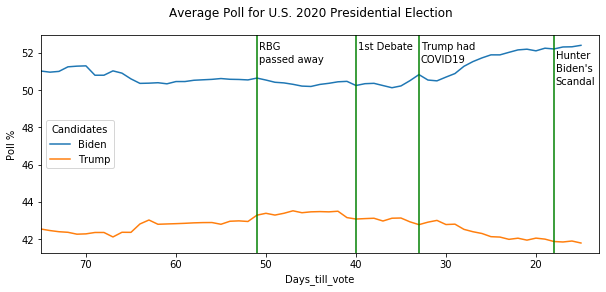

In [159]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1,figsize=(10,4))
poll_538.groupby(['Days_till_vote',"Candidates"]).mean()['Poll_est'].unstack().plot(ax=ax1)
ax1.axvline(33,color='g') #trump got covid
ax1.axvline(40,color='g') #presidential debate
ax1.axvline(51,color='g') #rbg passed away
ax1.axvline(18,color='g') #Hunter biden scandal
ax1.text(17.8, 51.7, 'Hunter')
ax1.text(17.8, 51, "Biden's")
ax1.text(17.8, 50.3, "Scandal")
ax1.text(32.8, 52.2, 'Trump had')
ax1.text(32.8, 51.5, 'COVID19')
ax1.text(39.8, 52.2, '1st Debate')
ax1.text(50.8, 52.2, 'RBG')
ax1.text(50.8, 51.5, 'passed away')
ax1.set_xlim(75,13)
ax1.set_ylabel('Poll %')
plt.suptitle('Average Poll for U.S. 2020 Presidential Election')
plt.show()

#### 3) FREQUENCY DISTRIBUTION OF COMPOUND SENTIMENT

The average VADER compound sentiments of their tweets are quite close, 0.15 for Donald Trump and 0.13 for Joe Biden. It is fair to say their tweets on average are neutral leaning towards positive sentiment, and Trump’s tweets have a slightly higher average sentiment. As we can see, the frequency distributions of the sentiments are quite similar for both candidates.

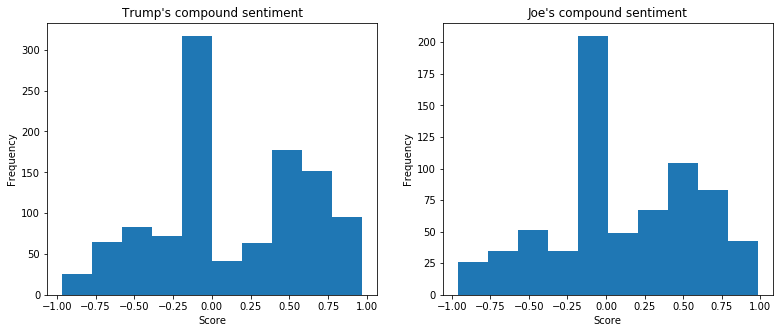

In [160]:
import matplotlib.pyplot as plt
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(13,5))
ax1.hist(tweet_trump_drop['vader_comp_sent'])
ax2.hist(tweet_joe_drop['vader_comp_sent'])
ax1.set_ylabel("Frequency")
ax2.set_ylabel("Frequency")
ax1.set_xlabel("Score")
ax2.set_xlabel("Score")
ax1.set_title("Trump's compound sentiment")
ax2.set_title("Joe's compound sentiment")
plt.show()

#### 4) WORD CLOUD OF TRUMP AND BIDEN’S TWEETS
After removing the stopwords, the most frequent word, occurred 106 times, in Trump’s tweets is “biden”. In Biden’s tweets, the most frequent word is “trump”, which occurred 127 times, a much higher frequency than Trump mentioning him considering the number of tweets they have.

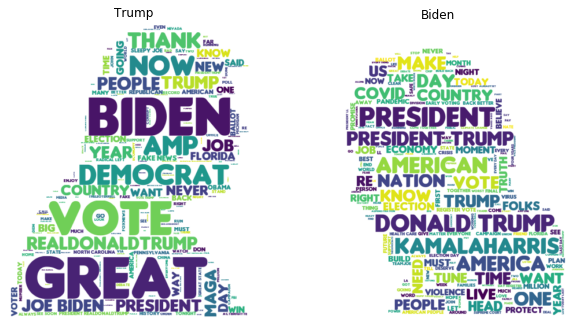

In [161]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib
from PIL import Image
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 12)

def generate_wordcloud(tweets,mask):
    tweets_con = ''
    wc_mask = np.array(Image.open(mask))
    tweets = tweets.text.values
    for t in tweets:
        tweets_con += t.lower()
    stopwords = set(STOPWORDS)
    stopwords.add("will")
    stopwords.add("https")
    stopwords.add("co")
    stopwords.add("rt")
    wc = WordCloud(background_color="white", 
                   font_path='Insanibc.ttf', 
                   stopwords=stopwords, 
                   mask=wc_mask,width=800, height=1000)
    return wc.generate(tweets_con)

fig=plt.figure()
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
trump_wc = generate_wordcloud(tweet_trump,"trump_mask.png")
biden_wc = generate_wordcloud(tweet_joe,"biden_mask.jpg")
ax1.imshow(trump_wc, interpolation='bilinear')
ax2.imshow(biden_wc, interpolation='bilinear')
ax1.set_title("Trump")
ax2.set_title("Biden")
ax1.axis('off')
ax2.axis('off')
plt.show()

### C) Regression Analysis

In [162]:
import statsmodels.regression.linear_model as sm 
X_combine = combine_df.iloc[:,0:17].values.reshape(1788,17)
regressor_OLS = sm.OLS(endog = Y_combine, exog = X_combine).fit()
regressor_OLS.summary(xname=combine_df.columns.tolist()[:17])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              2478.
Date:                Tue, 09 Feb 2021   Prob (F-statistic):                        0.00
Time:                        16:46:50   Log-Likelihood:                         -6513.3
No. Observations:                1788   AIC:                                  1.306e+04
Df Residuals:                    1771   BIC:                                  1.315e+04
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
days_till_vote                     1.1084      0.013     88.105      0.000       1.084       1.133
retweet_count                      0.0002   5.77e-05      4.014      0.000       0.000       0.000
favorite_count                  4.886e-05   1.03e-05      4.745      0.000    2.87e-05    6.91e-05
mention_oppo                       7.4760      1.679      4.452      0.000       4.182      10.770
mention_team                       4.2643      2.400      1.777      0.076      -0.444       8.972
vader_comp_sent                    5.8520      1.140      5.133      0.000       3.616       8.088
Power                              4.7303      0.213     22.259      0.000       4.314       5.147
Submit                             6.4656      0.582     11.103      0.000       5.323       7.608
Days_till_vote*retweet_count   -4.923e-06    1.7e-06     -2.898      0.004   -8.25e-06   -1.59e-06
Days_till_vote*favorite_count  -1.246e-06   3.17e-07     -3.935      0.000   -1.87e-06   -6.25e-07
Days_till_vote*mention_oppo       -0.1770      0.041     -4.287      0.000      -0.258      -0.096
Days_till_vote*mention_team       -0.0897      0.088     -1.024      0.306      -0.262       0.082
Days_till_vote*vader_comp_sent    -0.1348      0.027     -5.084      0.000      -0.187      -0.083
Days_till_vote*Power              -0.1038      0.005    -19.540      0.000      -0.114      -0.093
Days_till_vote*Submit             -0.1431      0.014    -10.180      0.000      -0.171      -0.115
Candidate                         19.5116      0.959     20.349      0.000      17.631      21.392
Days_till_vote*Candidate          -0.5890      0.025    -23.550      0.000      -0.638      -0.540
==============================================================================
Omnibus:                       39.640   Durbin-Watson:                   1.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.625
Skew:                           0.131   Prob(JB):                     6.24e-17
Kurtosis:                       3.966   Cond. No.                     6.27e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.27e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Mentioning opponent and teammate in the tweet

The p-value of the “mentioning opponent” variable is lower than 0.001. In this case, we are able to confirm that there is a relationship between mentioning opponent in tweets and polls. The coefficient is positive, which means mentioning opponents in tweets and polls are positively correlated.

The p-value of the “mention teammate” variable equals 0.076. It is possible that some of the explanatory power has shifted because of the two extra variables in the aggregated dataset. We could not reject the null hypothesis based on the aggregated dataset.

#### Sentiment and other variables

Independent variables with p-value < 0.05 and positive coefficient are VADER compound sentiment, Power tag, Submit tag, number of retweets, number of favorites, Candidates. There are positive correlation between these variables and poll. 

#### Importance of the feature when approaching vote day

When we look at the result of the interaction terms with Days till vote, the p-values for all variables, except mention_team, are below 0.01. Therefore, we are able to reject the null hypothesis and state that there is a linear relationship between these interaction terms and poll because the correlation coefficient is significantly different from 0. It is notable that all coefficients are negative, which means the importance of these variables is increasing when approaching the voting day.

Complete analysis can be found here: https://drive.google.com/file/d/1w-EKhAqNYEztFVIPNRBZbuxSZ0YVDcdH/view?usp=sharing